In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Task:   Select datases for regression from the UCI repositor: # https://archive.ics.uci.edu/datasets

# Following the data preprocessing protture, analyze the selected dats
1. Dataset Description
2. Basic Statistics
3. Identification of Missing Values
4. Data Simplification
5. Outlier Detection
6. Checking for Normal Distribution
7. Homogeneity of Variance
8. Variance Inflation Factor (VIF) Analysisues. 

### 1. Dataset Description

The Concrete Compressive Strength dataset was selected for regression analysis. It contains data on the compressive strength of concrete, consisting of 1,030 records, eight predictor variables, and one dependent variable.

In [2]:
# fetch dataset 
concrete_df = fetch_ucirepo(id=165)

X = concrete_df.data.features 
y = concrete_df.data.targets 

print(concrete_df.variables) 

                            name     role        type demographic description  \
0                         Cement  Feature  Continuous        None        None   
1             Blast Furnace Slag  Feature     Integer        None        None   
2                        Fly Ash  Feature  Continuous        None        None   
3                          Water  Feature  Continuous        None        None   
4               Superplasticizer  Feature  Continuous        None        None   
5               Coarse Aggregate  Feature  Continuous        None        None   
6                 Fine Aggregate  Feature  Continuous        None        None   
7                            Age  Feature     Integer        None        None   
8  Concrete compressive strength   Target  Continuous        None        None   

    units missing_values  
0  kg/m^3             no  
1  kg/m^3             no  
2  kg/m^3             no  
3  kg/m^3             no  
4  kg/m^3             no  
5  kg/m^3             no  


### 2. Basic Statistics

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              1030 non-null   float64
 1   Blast Furnace Slag  1030 non-null   float64
 2   Fly Ash             1030 non-null   float64
 3   Water               1030 non-null   float64
 4   Superplasticizer    1030 non-null   float64
 5   Coarse Aggregate    1030 non-null   float64
 6   Fine Aggregate      1030 non-null   float64
 7   Age                 1030 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 64.5 KB


In [4]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 1 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Concrete compressive strength  1030 non-null   float64
dtypes: float64(1)
memory usage: 8.2 KB


In [5]:
X.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000


In [6]:
y.describe()

,Concrete compressive strength
count,1030.000000
mean,35.817961
std,16.705742
min,2.330000
25%,23.710000
50%,34.445000
75%,46.135000
max,82.600000


### 3. Identification of Missing Values

In [7]:
X.isnull().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
dtype: int64

In [8]:
y.isnull().sum()

Concrete compressive strength    0
dtype: int64

### 4. Data Simplification

In [9]:
# Dodanie zmiennej docelowej do zbioru, aby łatwo policzyć korelacje
df_with_target = X.copy()
df_with_target['target'] = y

# Wyświetlenie korelacji cech z celem
correlation_matrix = df_with_target.corr()
target_corr = correlation_matrix['target'].drop('target').abs().sort_values(ascending=False)
print(target_corr)

# Wybór 4 cech o najwyższej korelacji ze zmienną docelową
top_features_corr = target_corr.index[:4]
X_reduced = X[top_features_corr]
print(f'Wybrane cechy: {list(top_features_corr)}')

Cement                0.497832
Superplasticizer      0.366079
Age                   0.328873
Water                 0.289633
Fine Aggregate        0.167241
Coarse Aggregate      0.164935
Blast Furnace Slag    0.134829
Fly Ash               0.105755
Name: target, dtype: float64
Wybrane cechy: ['Cement', 'Superplasticizer', 'Age', 'Water']


### 5. Outlier Detection
#### Box plots

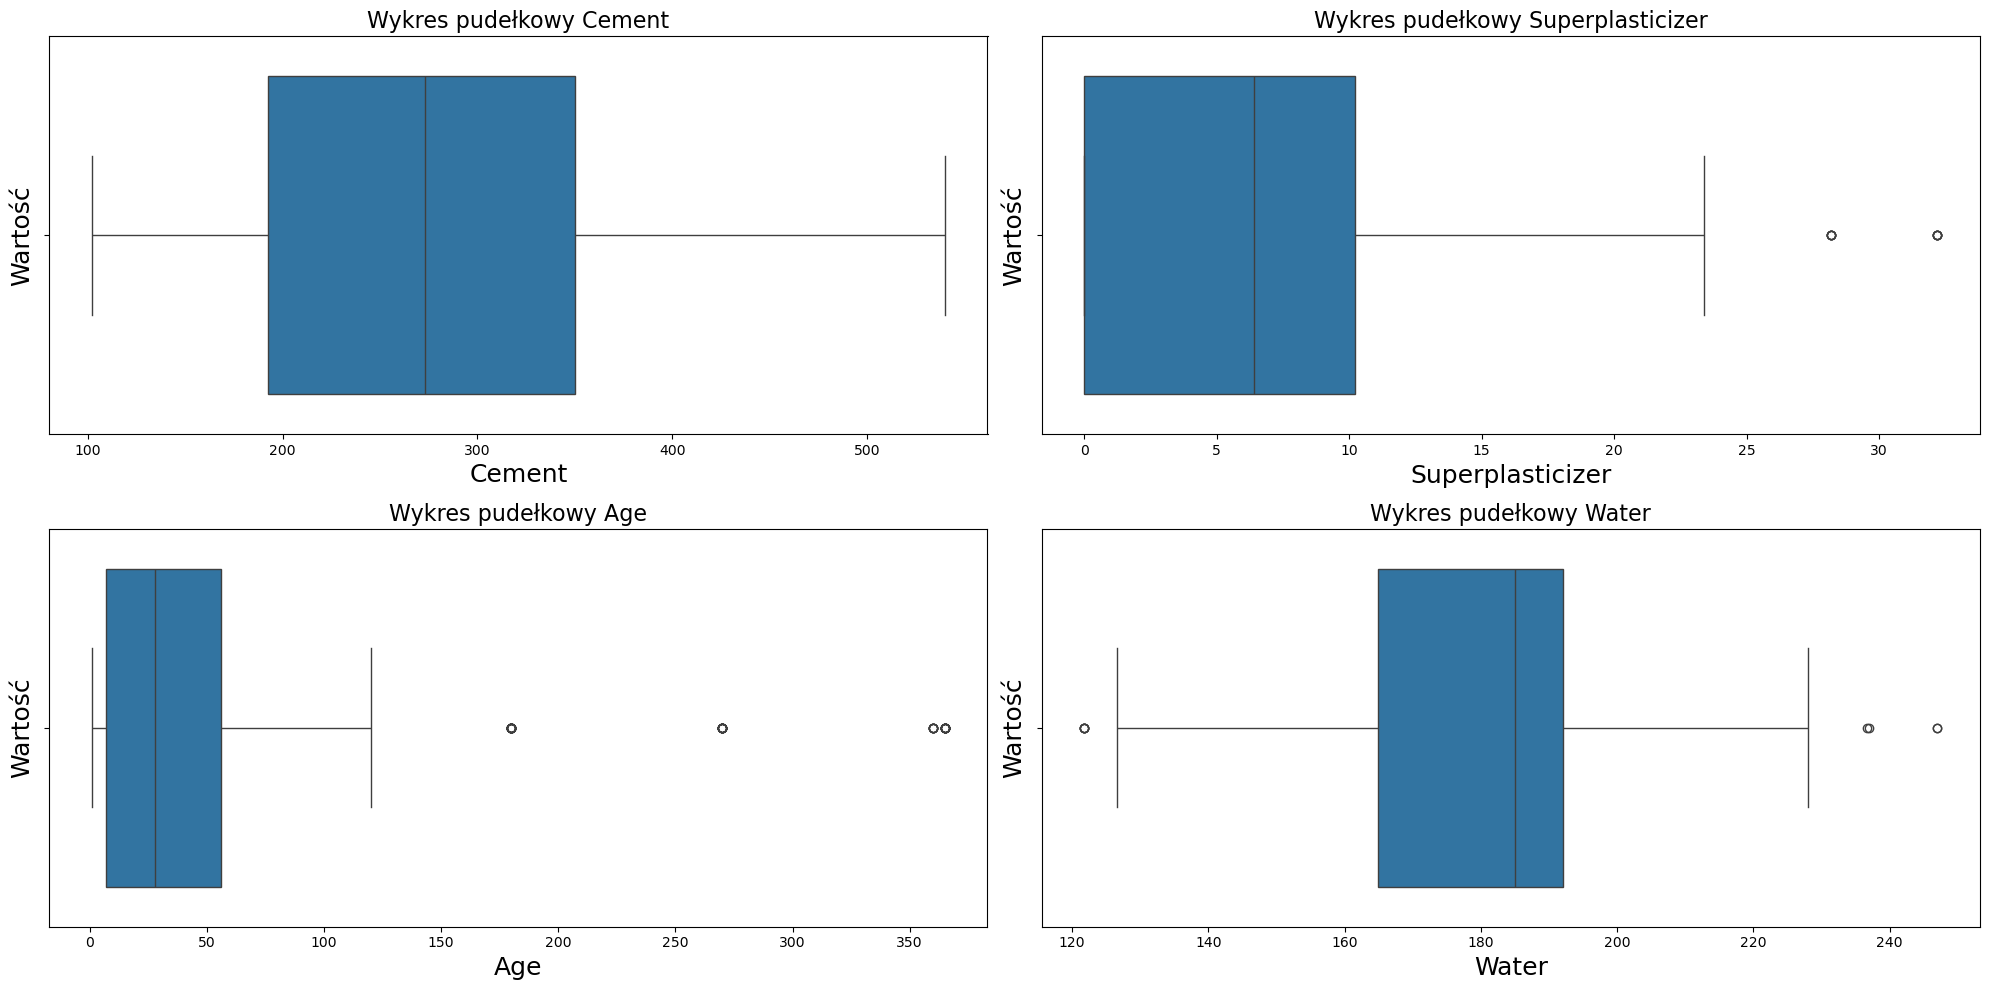

In [10]:
# Identyfikacja wartości odstających (wykresy pudełkowe)

plt.figure(figsize=(20, 10))
selected_features = ['Cement', 'Superplasticizer', 'Age', 'Water']


for i, column in enumerate(selected_features, 1):
    plt.subplot(2, 2, i)  # Ponieważ mamy 4 cechy, tworzymy 2 wiersze i 2 kolumny
    sns.boxplot(data=X, x=column)
    plt.title(f'Wykres pudełkowy {column}', fontsize=16)  # Zwiększenie rozmiaru czcionki tytułu
    plt.xlabel(column, fontsize=18)  # Dodanie etykiety osi X z większą czcionką
    plt.ylabel('Wartość', fontsize=18)  # Dodanie etykiety osi Y z większą czcionką


plt.tight_layout()
plt.show()


In [11]:
# Identyfikacja przedziałów wartości odstających dla każdej cechy w zbiorze X
outlier_bounds = {}

for column in selected_features:
    Q1 = X[column].quantile(0.25)
    Q3 = X[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Zapisanie dolnej i górnej granicy jako przedziału wartości odstających
    outlier_bounds[column] = (lower_bound, upper_bound)
    
    # Wyświetlenie wyników
    print(f'Przedział wartości odstających dla {column}:')
    print(f'Wartości poniżej: {lower_bound:.2f}, Wartości powyżej: {upper_bound:.2f}')
    print('---')

Przedział wartości odstających dla Cement:
Wartości poniżej: -44.06, Wartości powyżej: 586.44
---
Przedział wartości odstających dla Superplasticizer:
Wartości poniżej: -15.30, Wartości powyżej: 25.50
---
Przedział wartości odstających dla Age:
Wartości poniżej: -66.50, Wartości powyżej: 129.50
---
Przedział wartości odstających dla Water:
Wartości poniżej: 124.25, Wartości powyżej: 232.65
---


#### Three-sigma rule

In [12]:
# Inicjalizacja słownika do przechowywania granic wartości odstających
outlier_bounds_sigma = {}

# Sprawdzenie reguły trzech sigm dla każdej z wybranych cech
for column in selected_features:
    mean = X[column].mean()
    std = X[column].std()
    
    # Wyznaczenie przedziału według reguły trzech sigm
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    
    # Zapisanie dolnej i górnej granicy jako przedziału wartości odstających
    outlier_bounds_sigma[column] = (lower_bound, upper_bound)
    
    # Wyświetlenie wyników
    print(f'Przedział wartości odstających dla {column} (reguła trzech sigm):')
    print(f'Wartości poniżej: {lower_bound:.2f}, Wartości powyżej: {upper_bound:.2f}')
    print('---')

Przedział wartości odstających dla Cement (reguła trzech sigm):
Wartości poniżej: -32.35, Wartości powyżej: 594.69
---
Przedział wartości odstających dla Superplasticizer (reguła trzech sigm):
Wartości poniżej: -11.72, Wartości powyżej: 24.13
---
Przedział wartości odstających dla Age (reguła trzech sigm):
Wartości poniżej: -143.85, Wartości powyżej: 235.17
---
Przedział wartości odstających dla Water (reguła trzech sigm):
Wartości poniżej: 117.50, Wartości powyżej: 245.63
---


### 6. Checking for Normal Distribution
#### Statistical tests

In [13]:
# Sprawdzenie normalności rozkładu dla każdej z wybranych cech
for column in selected_features:
    data = X[column]
    
    # Test Shapiro-Wilka
    shapiro_stat, shapiro_p = stats.shapiro(data)
    
    # Test D'Agostino-Pearsona (normaltest)
    dagostino_stat, dagostino_p = stats.normaltest(data)
    
    # Wyświetlenie wyników testów statystycznych
    print(f'Normalność rozkładu dla {column}:')
    print(f'Test Shapiro-Wilka: statystyka={shapiro_stat:.4f}, p-value={shapiro_p:.4f}')
    print(f'Test D\'Agostino-Pearsona: statystyka={dagostino_stat:.4f}, p-value={dagostino_p:.4f}')
    
    # Interpretacja p-wartości
    if shapiro_p > 0.05:
        print(f'Wniosek (Shapiro-Wilk): {column} ma rozkład normalny (p > 0.05)')
    else:
        print(f'Wniosek (Shapiro-Wilk): {column} nie ma rozkładu normalnego (p <= 0.05)')
    
    if dagostino_p > 0.05:
        print(f'Wniosek (D\'Agostino-Pearson): {column} ma rozkład normalny (p > 0.05)')
    else:
        print(f'Wniosek (D\'Agostino-Pearson): {column} nie ma rozkładu normalnego (p <= 0.05)')
    print('---')

Normalność rozkładu dla Cement:
Test Shapiro-Wilka: statystyka=0.9590, p-value=0.0000
Test D'Agostino-Pearsona: statystyka=61.7596, p-value=0.0000
Wniosek (Shapiro-Wilk): Cement nie ma rozkładu normalnego (p <= 0.05)
Wniosek (D'Agostino-Pearson): Cement nie ma rozkładu normalnego (p <= 0.05)
---
Normalność rozkładu dla Superplasticizer:
Test Shapiro-Wilka: statystyka=0.8660, p-value=0.0000
Test D'Agostino-Pearsona: statystyka=140.2781, p-value=0.0000
Wniosek (Shapiro-Wilk): Superplasticizer nie ma rozkładu normalnego (p <= 0.05)
Wniosek (D'Agostino-Pearson): Superplasticizer nie ma rozkładu normalnego (p <= 0.05)
---
Normalność rozkładu dla Age:
Test Shapiro-Wilka: statystyka=0.5907, p-value=0.0000
Test D'Agostino-Pearsona: statystyka=727.4789, p-value=0.0000
Wniosek (Shapiro-Wilk): Age nie ma rozkładu normalnego (p <= 0.05)
Wniosek (D'Agostino-Pearson): Age nie ma rozkładu normalnego (p <= 0.05)
---
Normalność rozkładu dla Water:
Test Shapiro-Wilka: statystyka=0.9804, p-value=0.0000
T

#### Q-Q plots

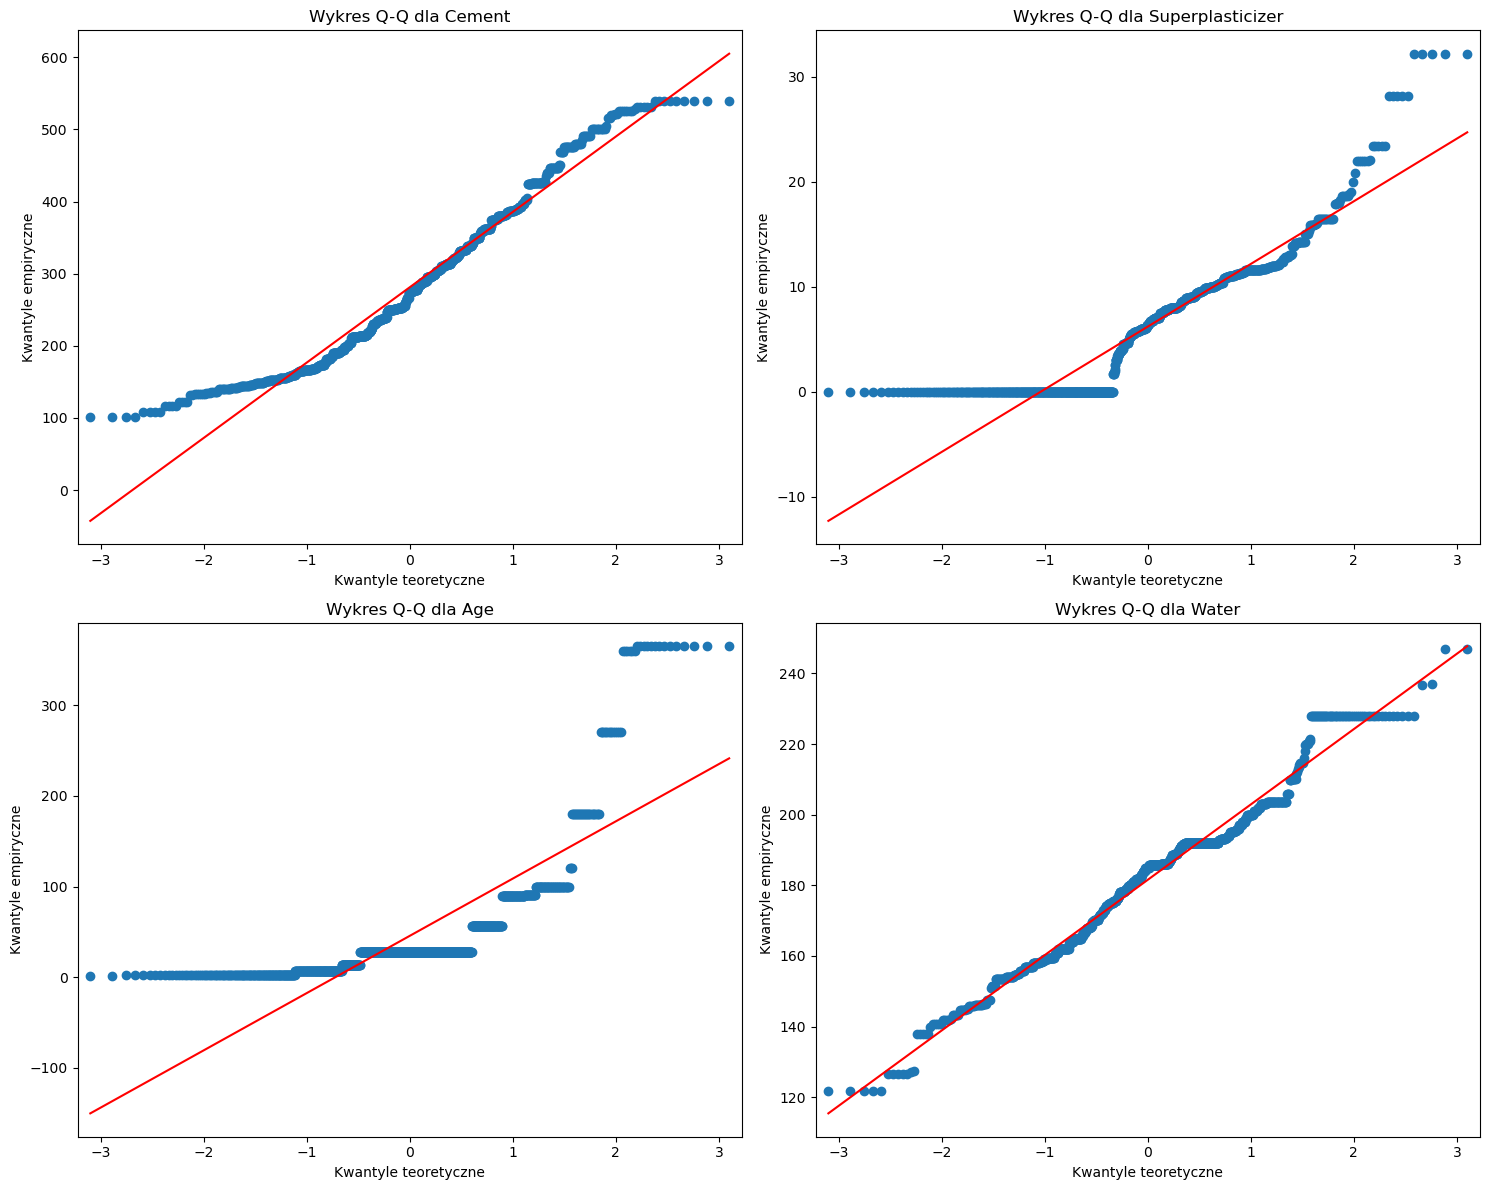

In [14]:
# Ustawienie figury z subplots (2 wiersze, 2 kolumny)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Iterowanie przez każdą z cech i tworzenie wykresu Q-Q
for i, column in enumerate(selected_features):
    row, col = divmod(i, 2)  # Określenie wiersza i kolumny w siatce subplotów
    sm.qqplot(X[column], line='s', ax=axes[row, col])  # Tworzenie wykresu Q-Q na odpowiedniej osi
    axes[row, col].set_title(f'Wykres Q-Q dla {column}')  # Ustawienie tytułu
    axes[row, col].set_xlabel('Kwantyle teoretyczne')  # Ustawienie etykiety osi X
    axes[row, col].set_ylabel('Kwantyle empiryczne')  # Ustawienie etykiety osi Y

plt.tight_layout()  # Ustawienie, aby wykresy były czytelnie rozmieszczone
plt.show()

### 7. Homogeneity of Variance

In [15]:
# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dopasowanie modelu regresji liniowej
model = LinearRegression()
model.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred = model.predict(X_test)

# Obliczenie reszt (błędy predykcji)
residuals = y_test - y_pred

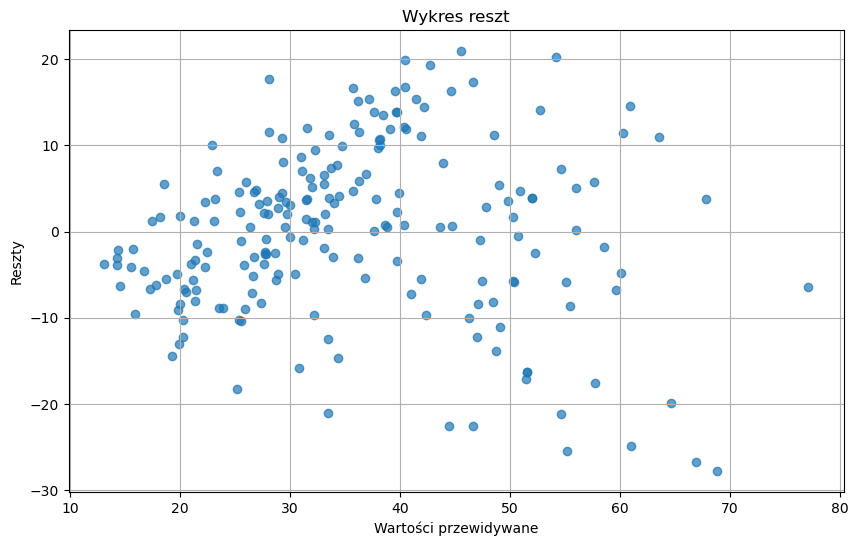

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.xlabel('Wartości przewidywane')
plt.ylabel('Reszty')
plt.title('Wykres reszt')
plt.grid()
plt.show()

### 8. Variance Inflation Factor (VIF) Analysis

In [17]:
# Wybór danych dla wybranych cech
X_selected = X[selected_features]

# Dodanie wyrazu wolnego (stałej) do macierzy cech
X_with_const = sm.add_constant(X_selected)

# Obliczenie VIF dla każdej zmiennej
vif_data = pd.DataFrame()
vif_data['Feature'] = X_with_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Wyświetlenie wyników
print(vif_data)

            Feature         VIF
0             const  163.226911
1            Cement    1.021778
2  Superplasticizer    1.767042
3               Age    1.097025
4             Water    1.842836
